In [1]:
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
import scipy.sparse.linalg
import sklearn.cluster as sl
import torch
import matplotlib.pyplot as plt

In [2]:
def sqrtinvdiag(M):
    """Inverts and square-roots a positive diagonal matrix.
    Args:
        M (csc matrix): matrix to invert
    Returns:
        scipy sparse matrix of inverted square-root of diagonal
    """

    d = M.diagonal()
    dd = [1 / max(np.sqrt(x), 1 / 999999999) for x in d]

    return sp.dia_matrix((dd, [0]), shape=(len(d), len(d))).tocsc()

In [3]:
adj = sp.load_npz('./Business/Business_FM_Full_adj.npz')
adj

<113x113 sparse matrix of type '<class 'numpy.int64'>'
	with 1787 stored elements in Compressed Sparse Row format>

[ 0  1  2  4  5 14  3  6 10 16 21 24  8 12  7  9 33 23 30 26 22 48 59 15
 36 17 11 43 71 66 20 29 25 18 45 34 27 40 13 35 37 91 41 54 50 44 94 87
 32 55 79 42 62 81 19 67 52 49 83 53 98 85 46 78 39 57 38 84 61 76 70 56
 75 31 96 77 51 73 88 92 74 64 72 93 68 86 69 60 97 65 58 47 90 63 82 28
 95 89 80]
[9.54991362e-01 1.04386070e-01 1.00424572e-01 1.53252012e-02
 4.52120509e-02 2.77973711e-02 1.29998773e-02 1.02718023e-02
 1.06430830e-02 9.51001151e-03 1.28292838e-02 6.02516512e-03
 1.06252398e-02 3.95273971e-03 1.62249919e-02 6.80121810e-03
 1.25666533e-02 6.10631078e-03 4.64636331e-03 2.79859535e-03
 5.58969184e-03 1.11789695e-02 7.77645545e-03 8.65372626e-03
 1.11190778e-02 5.09507371e-03 8.07318815e-03 4.07609207e-03
 7.22188014e-04 5.40615917e-03 8.44161507e-03 1.72551864e-03
 3.16068369e-03 8.82714162e-03 4.28844832e-03 3.79694017e-03
 6.19789261e-03 3.78103085e-03 2.31474891e-03 2.48233838e-03
 3.97966529e-03 3.69998435e-03 3.03829646e-03 5.93758939e-03
 3.36587881e-03 4.47955473

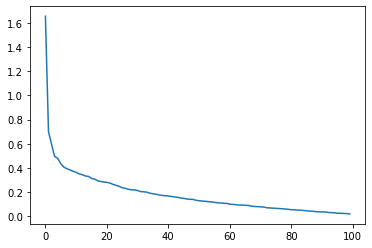

In [4]:
A = adj.tocsc()
D_out = sp.diags(A.transpose().sum(
    axis=0).tolist(), [0]).tocsc()
D_in = sp.diags(A.sum(axis=0).tolist(), [0]).tocsc()
Dbar = (D_in + D_out)
d = sqrtinvdiag(Dbar)
normA = d * A * d
size = A.shape[0]
H = (A-A.transpose()) * 1j
H_abs = np.abs(H)
D_abs_inv = sp.diags(1/np.array(H_abs.sum(1))[:, 0])
D_abs_inv.data[np.isinf(D_abs_inv.data)] = 0.0
H_rw = D_abs_inv.dot(H)
_, s, _ = sp.linalg.svds(H_rw, 100)
eigens = s[list(np.arange(99,-1,-1))]
eigengaps = eigens[:-1] - eigens[1:]
print(np.argsort(-eigengaps))
print(eigengaps)
plt.plot(eigens)
plt.show()
# choose K = 5

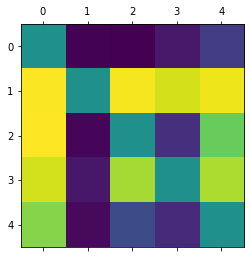

6

In [5]:
num_clusters = 5
u, s, vt = sp.linalg.svds(H_rw, num_clusters)
features_SVD = np.concatenate((np.real(u), np.imag(u)), axis=1)
labels = sl.KMeans(n_clusters=num_clusters).fit_predict(features_SVD)
A = torch.FloatTensor(A.toarray())
P = torch.zeros(labels.shape[0], num_clusters).to(A.device)
for k in range(num_clusters):
    P[labels == k, k] = 1
flow_mat = np.ones([num_clusters, num_clusters])*0.5
for k in range(num_clusters-1):
    for l in range(k+1, num_clusters):
        w_kl = torch.matmul(P[:, k], torch.matmul(A, P[:, l])).item()
        w_lk = torch.matmul(P[:, l], torch.matmul(A, P[:, k])).item()
        if (w_kl + w_lk) > 0:
            flow_mat[k, l] = w_kl/(w_kl + w_lk)
            flow_mat[l, k] = w_lk/(w_kl + w_lk)
plt.matshow(flow_mat)
plt.show()
np.sum(flow_mat>0.9)

In [6]:
adj = sp.load_npz('./ComputerScience/ComputerScience_FM_Full_adj.npz')
adj

<206x206 sparse matrix of type '<class 'numpy.int64'>'
	with 1407 stored elements in Compressed Sparse Row format>

[ 0  1  3  8  9 10  7 16 12 26 21 18 30 23 19 27 32 45 17 40 58 52 13 47
 35 43 14 41 25 71 86 37 15 29 60 49 36 69 62 22 48 56 24  5 65 95  2 64
 44 67 75 50 89 34 78 31 42 91 72 74 94 98 79 84 39 77 53 51 63 59 81 92
 68 33 87 93 80 83 70 82 73 97 28 54 88 76 38 61 46  4 85  6 20 55 90 11
 66 57 96]
[1.25509429e+00 3.85703789e-01 5.63006818e-03 1.39945220e-01
 1.76239800e-03 5.98548006e-03 1.64894639e-03 4.38120746e-02
 6.68399981e-02 6.22923130e-02 4.51137640e-02 5.57930829e-04
 2.51149808e-02 1.14024302e-02 9.98741040e-03 7.60193874e-03
 3.07037861e-02 1.33440624e-02 1.69353125e-02 1.58696069e-02
 1.59651836e-03 1.91726447e-02 6.64311972e-03 1.61513618e-02
 6.00858234e-03 9.09275514e-03 2.36279864e-02 1.50458080e-02
 2.37807210e-03 7.51106545e-03 1.62727473e-02 4.85161167e-03
 1.46903253e-02 3.61044920e-03 5.01854048e-03 1.09461312e-02
 7.34316914e-03 8.32196587e-03 2.13614869e-03 4.04449686e-03
 1.29674712e-02 9.28917714e-03 4.67125009e-03 1.00295160e-02
 5.56898290e-03 1.45632660

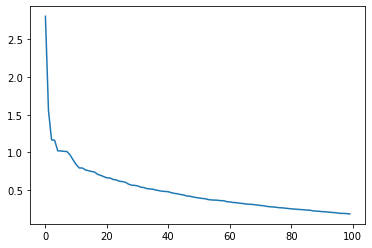

In [7]:
A = adj.tocsc()
D_out = sp.diags(A.transpose().sum(
    axis=0).tolist(), [0]).tocsc()
D_in = sp.diags(A.sum(axis=0).tolist(), [0]).tocsc()
Dbar = (D_in + D_out)
d = sqrtinvdiag(Dbar)
normA = d * A * d
size = A.shape[0]
H = (A-A.transpose()) * 1j
H_abs = np.abs(H)
D_abs_inv = sp.diags(1/np.array(H_abs.sum(1))[:, 0])
D_abs_inv.data[np.isinf(D_abs_inv.data)] = 0.0
H_rw = D_abs_inv.dot(H)
_, s, _ = sp.linalg.svds(H_rw, 100)
eigens = s[list(np.arange(99,-1,-1))]
eigengaps = eigens[:-1] - eigens[1:]
print(np.argsort(-eigengaps))
print(eigengaps)
plt.plot(eigens)
plt.show()
# choose K = 9

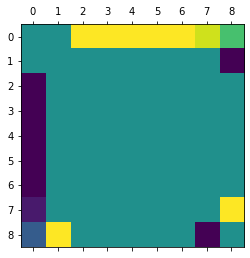

8

In [8]:
num_clusters = 9
u, s, vt = sp.linalg.svds(H_rw, num_clusters)
features_SVD = np.concatenate((np.real(u), np.imag(u)), axis=1)
labels = sl.KMeans(n_clusters=num_clusters).fit_predict(features_SVD)
A = torch.FloatTensor(A.toarray())
P = torch.zeros(labels.shape[0], num_clusters).to(A.device)
for k in range(num_clusters):
    P[labels == k, k] = 1
flow_mat = np.ones([num_clusters, num_clusters])*0.5
for k in range(num_clusters-1):
    for l in range(k+1, num_clusters):
        w_kl = torch.matmul(P[:, k], torch.matmul(A, P[:, l])).item()
        w_lk = torch.matmul(P[:, l], torch.matmul(A, P[:, k])).item()
        if (w_kl + w_lk) > 0:
            flow_mat[k, l] = w_kl/(w_kl + w_lk)
            flow_mat[l, k] = w_lk/(w_kl + w_lk)
plt.matshow(flow_mat)
plt.show()
np.sum(flow_mat>0.9)

In [9]:
adj = sp.load_npz('./History/History_FM_Full_adj.npz')
adj

<145x145 sparse matrix of type '<class 'numpy.int64'>'
	with 1204 stored elements in Compressed Sparse Row format>

[ 0  1  3  2 11  5 15 13 16  4 17  6 25  9  8 10 19 28 21 30  7 20 23 42
 50 24 33 46 35 32 67 31 18 27 12 44 40 59 74 14 62 38 53 58 60 93 64 39
 26 68 87 55 56 66 77 48 34 54 47 51 88 52 80 22 75 65 84 61 97 83 41 81
 57 63 43 90 79 70 76 96 72 45 94 37 49 36 86 73 89 29 91 98 82 71 92 95
 85 69 78]
[7.60160347e-01 1.62874038e-01 8.26628615e-02 9.16216157e-02
 2.54231795e-02 5.60144150e-02 2.21564390e-02 1.37929988e-02
 1.84867841e-02 1.96589958e-02 1.81385577e-02 6.93552577e-02
 7.25385793e-03 2.77236862e-02 5.39503466e-03 2.79923176e-02
 2.67950298e-02 2.39365218e-02 8.37301826e-03 1.76879069e-02
 1.36200656e-02 1.47113399e-02 3.20378145e-03 1.26588254e-02
 1.04236915e-02 2.12066236e-02 4.46445936e-03 7.71201538e-03
 1.71851322e-02 1.27143385e-03 1.38480033e-02 8.43300896e-03
 8.59181569e-03 9.80237893e-03 3.77798673e-03 8.88651852e-03
 1.67555825e-03 1.76640414e-03 5.31331789e-03 4.46695713e-03
 6.24534453e-03 2.87748472e-03 1.26159292e-02 2.71593808e-03
 6.24692908e-03 1.78792972

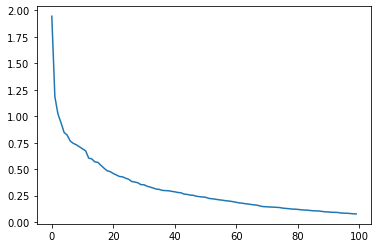

In [10]:
A = adj.tocsc()
D_out = sp.diags(A.transpose().sum(
    axis=0).tolist(), [0]).tocsc()
D_in = sp.diags(A.sum(axis=0).tolist(), [0]).tocsc()
Dbar = (D_in + D_out)
d = sqrtinvdiag(Dbar)
normA = d * A * d
size = A.shape[0]
H = (A-A.transpose()) * 1j
H_abs = np.abs(H)
D_abs_inv = sp.diags(1/np.array(H_abs.sum(1))[:, 0])
D_abs_inv.data[np.isinf(D_abs_inv.data)] = 0.0
H_rw = D_abs_inv.dot(H)
_, s, _ = sp.linalg.svds(H_rw, 100)
eigens = s[list(np.arange(99,-1,-1))]
eigengaps = eigens[:-1] - eigens[1:]
print(np.argsort(-eigengaps))
print(eigengaps)
plt.plot(eigens)
plt.show()
# choose K = 12

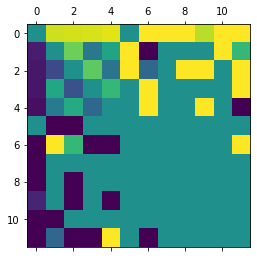

22

In [11]:
num_clusters = 12
u, s, vt = sp.linalg.svds(H_rw, num_clusters)
features_SVD = np.concatenate((np.real(u), np.imag(u)), axis=1)
labels = sl.KMeans(n_clusters=num_clusters).fit_predict(features_SVD)
A = torch.FloatTensor(A.toarray())
P = torch.zeros(labels.shape[0], num_clusters).to(A.device)
for k in range(num_clusters):
    P[labels == k, k] = 1
flow_mat = np.ones([num_clusters, num_clusters])*0.5
for k in range(num_clusters-1):
    for l in range(k+1, num_clusters):
        w_kl = torch.matmul(P[:, k], torch.matmul(A, P[:, l])).item()
        w_lk = torch.matmul(P[:, l], torch.matmul(A, P[:, k])).item()
        if (w_kl + w_lk) > 0:
            flow_mat[k, l] = w_kl/(w_kl + w_lk)
            flow_mat[l, k] = w_lk/(w_kl + w_lk)
plt.matshow(flow_mat)
plt.show()
np.sum(flow_mat>0.9)